In [1]:
import cv2
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, Adagrad
from sklearn.model_selection import train_test_split

from cleverhans.utils_tf import batch_eval
from cleverhans.attacks import FastGradientMethod
from tensorflow.python.platform import flags

from sklearn.datasets import fetch_mldata
%matplotlib inline
FLAGS = flags.FLAGS

Using TensorFlow backend.


In [2]:
flags.DEFINE_integer('img_dim', 12, 'img.size = (n, n)')
flags.DEFINE_integer('nb_epochs', 6, 'Number of epochs to train model')
flags.DEFINE_integer('batch_size', 128, 'Size of training batches')
flags.DEFINE_float('learning_rate', 0.1, 'Learning rate for training')

def resize(image, size=(FLAGS.img_dim, FLAGS.img_dim)): return cv2.resize(image, size).flatten()

In [3]:
digits = {}
mnist = fetch_mldata('MNIST original', data_home='data/')
digits['target'] = mnist['target'][(mnist['target'] == 0) | (mnist['target'] == 1)]
digits['data'] = mnist['data'][(mnist['target'] == 0) | (mnist['target'] == 1)]
digits['data'] = map(lambda img: img.reshape(28, 28), digits['data'])

classes, ids = np.unique(digits['target'], return_inverse=True)
labels = np_utils.to_categorical(ids, len(classes))

data = map(resize, digits['data'])
data = np.array(data)/255.0

(trainData, testData, trainLabels, testLabels) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [4]:
sess = tf.Session()
keras.backend.set_session(sess)

model = Sequential()
model.add(Dense(200, input_shape=trainData[0].shape, kernel_initializer="uniform", activation="tanh"))
model.add(Dense(100, kernel_initializer="uniform", activation="tanh"))
model.add(Dense(labels.shape[1]))
model.add(Activation("softmax"))

In [5]:
sgd = SGD(lr=0.01)
adagrad = Adagrad(lr=0.01)
adam = Adam(lr=0.01)
params = {'batch_size': FLAGS.batch_size, 'epochs':FLAGS.nb_epochs}
model.compile(loss="binary_crossentropy", optimizer=adagrad, metrics=["accuracy"])
model.fit(trainData, trainLabels, epochs=FLAGS.nb_epochs, batch_size=FLAGS.batch_size, verbose=1)

print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(testData, testLabels, batch_size=FLAGS.batch_size, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy*100))

Epoch 1/6
11085/11085 [==============================] - 0s - loss: 0.0205 - acc: 0.9904      
Epoch 2/6
11085/11085 [==============================] - 0s - loss: 0.0039 - acc: 0.9986     

In [6]:
import theano
import pymc3 as pm
import theano.tensor as T

In [7]:
trainLabels = classes[trainLabels.argmax(1)]
ann_input = theano.shared(trainData)
ann_output = theano.shared(trainLabels)

In [8]:
d_1 = (trainData.shape[1], 200)
d_2 = (200, 100)
d_3 = (100,)

with pm.Model() as neural_network:
    W_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=d_1, testval=np.random.randn(*d_1))
    W_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=d_2, testval=np.random.randn(*d_2))
    W_2_out = pm.Normal('w_2_out', 0, sd=1, shape=d_3, testval=np.random.randn(*d_3))
    
    act_1 = T.tanh(T.dot(ann_input, W_in_1))
    act_2 = T.tanh(T.dot(act_1, W_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, W_2_out))
    
    """    
    act_1 = T.nnet.relu(T.dot(ann_input, W_in_1))
    act_2 = T.nnet.relu(T.dot(act_1, W_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, W_2_out))
    
    """    
    out = pm.Bernoulli('out', act_out, observed=ann_output) # Binary classification -> Bernoulli likelihood
                                                            # what about multi-class?

/usr/local/lib/python2.7/site-packages/theano/tensor/basic.py:2124: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [9]:
from pymc3 import NUTS, sample, find_MAP, Slice, traceplot

with neural_network:
    v_params = pm.variational.advi(n=1000)

Average ELBO = -28,489: 100%|██████████| 1000/1000 [04:04<00:00,  4.07it/s]
Finished [100%]: Average ELBO = -26,869


In [10]:
with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=3001)

100%|██████████| 3001/3001 [00:13<00:00, 229.34it/s]


100%|██████████| 500/500 [00:31<00:00, 15.92it/s]


Accuracy = 99.648173207%


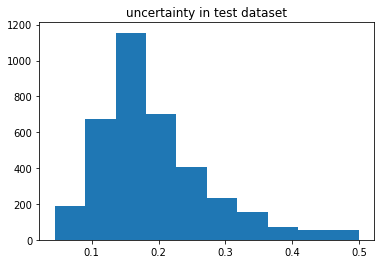

In [11]:
testLabels = classes[testLabels.argmax(1)]
ann_input.set_value(testData)
ann_output.set_value(testLabels)

ppc = pm.sample_ppc(trace, model=neural_network, samples=500) # Creater posterior predictive samples
pred = ppc['out'].mean(axis=0) > 0.5 # Use probability of > 0.5 to assume prediction of class 1
print('Accuracy = {}%'.format((testLabels == pred).mean() * 100))
plt.hist(ppc['out'].std(axis=0));
plt.title('uncertainty in test dataset')

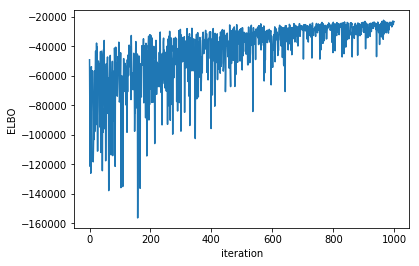

In [12]:
plt.plot(v_params.elbo_vals);
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [13]:
idx = mnist['target'] == 1
in_dist_img = map(lambda img: img.reshape(28, 28), mnist['data'][idx])
in_dist = np.array(map(resize, in_dist_img))/255.0

ann_input.set_value(in_dist)
ann_output.set_value(np.ones(in_dist.shape[1]))

in_dist_ppc = pm.sample_ppc(trace, model=neural_network, samples=500);
in_dist_means = in_dist_ppc['out'].mean(axis=0)
in_dist_stds = in_dist_ppc['out'].std(axis=0)

100%|██████████| 500/500 [01:02<00:00,  7.89it/s]


In [14]:
idx = mnist['target'] == 3
out_of_dist_img = map(lambda img: img.reshape(28, 28), mnist['data'][idx])
out_of_dist = np.array(map(resize, out_of_dist_img))/255.0

ann_input.set_value(out_of_dist)
ann_output.set_value(np.ones(out_of_dist.shape[1]))

out_of_dist_ppc = pm.sample_ppc(trace, model=neural_network, samples=500)
out_of_dist_means = out_of_dist_ppc['out'].mean(axis=0)
out_of_dist_stds = out_of_dist_ppc['out'].std(axis=0)

100%|██████████| 500/500 [00:58<00:00,  9.11it/s]


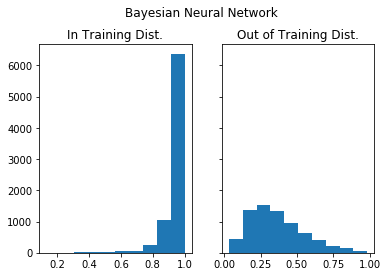

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True);
ax1.hist(in_dist_means);
ax1.set_title('In Training Dist.');
ax2.hist(out_of_dist_means);
ax2.set_title('Out of Training Dist.');
fig.suptitle('Bayesian Neural Network');
fig.subplots_adjust(top=0.85)

These two distributions from the BNN tell two very different stories. On the left, the distribution leans strongly towards high-confidence predictions of the input being 1 (correct classification). On the right, when the BNN was given input that was not in the distribution of training data, the network has very low confidence in its predictions; this can be seen in the lack of a defined peak in the distribution.

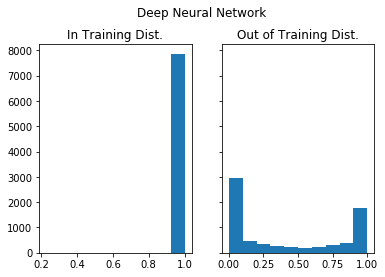

In [16]:
out_of_dist_predictions = [b for (a, b) in model.predict(out_of_dist)]  # how much it predicts a 3 is a 1
in_dist_predictions = [b for (a, b) in model.predict(in_dist)]       # how much it preidcts a 1 is a 1

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True);
ax1.hist(in_dist_predictions);
ax1.set_title('In Training Dist.');
ax2.hist(out_of_dist_predictions);
ax2.set_title('Out of Training Dist.');
fig.suptitle('Deep Neural Network');
fig.subplots_adjust(top=0.85)

Here, our deep neural network performes equally well on data represented by the same distribution as our training data (ie, 0s and 1s). However, at right, we see extremely high probabilities assigned to the out of training data distribution predictions (ie, when the deep net is given a 3). It predicts with ~100% probability, or ~0% probability, that the 3 is a 0 or a 1. Absolute confidence in it's completely inaccurate prediction.

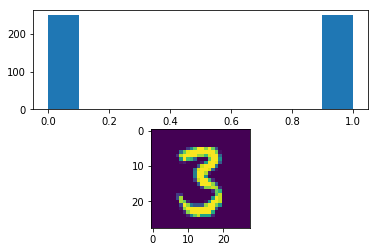

In [17]:
confidences = sorted(enumerate(out_of_dist_stds), key=lambda (a,b): b, reverse=True)

out_of_dist_idx = confidences[0][0]
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(out_of_dist_ppc['out'][:, out_of_dist_idx]);
ax2.imshow(out_of_dist_img[out_of_dist_idx]);

here we see that the BNN is very uncertain whether the 3 is a 0 or a 1. As it should. Note that the ANN can give us only one (likely very over-confident) result for this particular classification.

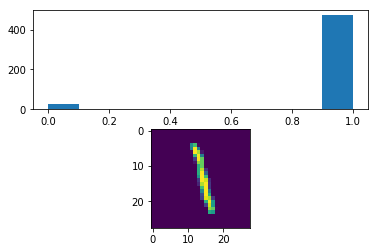

In [18]:
"""these plots are aggregates of all examples, another aproach would be to focus on a single image""";
"""would perhaps be more demonstrative. """;

confidences = sorted(enumerate(in_dist_stds), key=lambda (a,b): b, reverse=False)

in_dist_idx = confidences[5000][0]
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(in_dist_ppc['out'][:, in_dist_idx]);
ax2.imshow(in_dist_img[in_dist_idx]);

here we see the BNN very certain that the 1 is a 1. As it should.

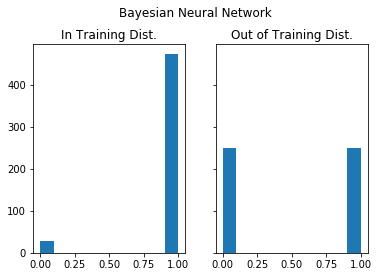

In [19]:
in_dist_predictions= [sample[in_dist_idx] for sample in in_dist_ppc['out']]
out_of_dist_predictions = [sample[out_of_dist_idx] for sample in out_of_dist_ppc['out']]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True);
ax1.hist(in_dist_predictions);
ax1.set_title('In Training Dist.');
ax2.hist(out_of_dist_predictions);
ax2.set_title('Out of Training Dist.');
fig.suptitle('Bayesian Neural Network');
fig.subplots_adjust(top=0.85)

Rosey comparison of how perfect Bayesian is at being uncertain in predictions on out of distribution data. Unfortunately, there are maaany of examples where the BNN predicts 3s to be 1s with no uncertainty (ie, every sample of the postierior classifies the 3 as a 1). Good news is, however, that there are relatively few cases of such low uncertainty.

In [20]:
x = tf.placeholder(tf.float32, shape=model.input.shape)
y = tf.placeholder(tf.float32, shape=model.output.shape)
predictions = model(x)

In [21]:
fgsm_params = {'eps': 0.175, 'batch_size':FLAGS.batch_size}
fgsm = FastGradientMethod(model, sess=sess)
adv_x = fgsm.generate(x, **fgsm_params)

testData_adversarial, = batch_eval(sess, [x], [adv_x], [testData])

/Users/rob/ias/SoSe_2017/neural_nets/seminar/src/cleverhans/cleverhans/utils_tf.py:33: UserWarning: Setting parameters (batch_size) from TensorFlow FLAGS is deprecated.
  'deprecated.'.format(name))


In [22]:
testLabels = np_utils.to_categorical(testLabels, len(classes))

print '[INFO] evaluating on adversarial test set...'
(loss, accuracy) = model.evaluate(testData_adversarial, testLabels, batch_size=FLAGS.batch_size, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy*100))

[INFO] evaluating on adversarial test set...
2432/3695 [==================>...........] - ETA: 0s[INFO] loss=13.9404, accuracy: 0.8390%


Normal Neural network was, as expected, very effectively tricked.

100%|██████████| 500/500 [00:32<00:00, 14.90it/s]


Accuracy = 91.2855209743%


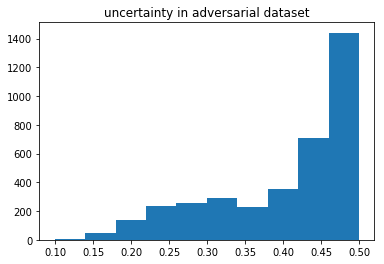

In [23]:
testLabels = classes[testLabels.argmax(1)]
ann_input.set_value(testData_adversarial)
ann_output.set_value(testLabels)

ppc = pm.sample_ppc(trace, model=neural_network, samples=500) # Creater posterior predictive samples
pred = ppc['out'].mean(axis=0) > 0.5 # Use probability of > 0.5 to assume prediction of class 1
print('Accuracy = {}%'.format((testLabels == pred).mean() * 100))
plt.hist(ppc['out'].std(axis=0));
plt.title('uncertainty in adversarial dataset')

interestingly, **the BNN actually does exhibit significantly more uncertainty** in while evaluating the adversarial examples than in the graph for uncertainty in the test dataset 

    figure is found above, titled: "uncertainty in test dataset"

It is worth noting, however, that **these adversarial examples were generated for the ANN, not for the BNN**. Not sure how to do that yet (or if it's possible).

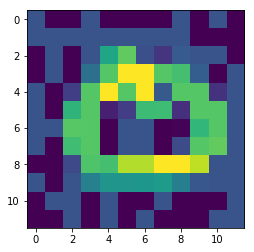

In [24]:
img = testData_adversarial[7]
plt.imshow(255*img.reshape(12, 12));

In [25]:
p = model.predict(np.array([img]))
print 'Deep NN prediction: {0:0.2f}% chance that the 0 is 1'.format(100*p[0][1])

Deep NN prediction: 99.92% chance that the 0 is 1


In [26]:
ann_input.set_value(np.array([img]))
ann_output.set_value([1])

in_dist_ppc = pm.sample_ppc(trace, model=neural_network, samples=1000)
in_dist_means = in_dist_ppc['out'].mean(axis=0)
in_dist_stds = in_dist_ppc['out'].std(axis=0)

100%|██████████| 1000/1000 [00:14<00:00, 70.60it/s]


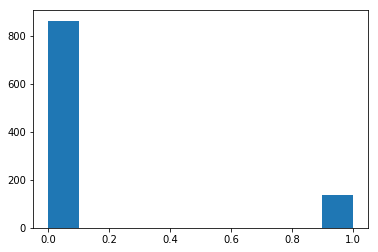

In [27]:
plt.hist(in_dist_ppc['out']);

still pretty confident that it's a zero in this particular case. 

I think the adversarial exemples need to be generated specifically for each network..but am not sure. Look into whether they are only functions of the architecture, or whether specific weights matter.